In [1]:
import requests
import pandas as pd
import time
import random
import seaborn as sns
import numpy as np

# This Project 
1. Create models to predict whether a post belongs in the 'Smite' subreddit
2. The posts will be a mixture of posts from 'Heroes of the Storm' and 'Smite' subreddit

## Objective:
1. Identifies what topics/word from Smite and HoTS are most interested by reddit users
2. Identifies quality of the model and its limitations

# Importing Data

url = 'https://www.reddit.com/r/Heroesofthestorm/.json'

In [2]:
url = 'https://www.reddit.com/r/smite/.json'

In [3]:
posts = []

In [4]:
after = None

### Note: I'm running the code below for both urls multiple times to get a decent sample size.

# EDA/CLEAN:

### Create a usable data frame

# Cleaning:
1. Drop Duplicates
2. Check null/Drop null

There are decent amount of data that have empty selftext. We will drop them since we are still are left with good enough sample size

# Export/Import The Clean Data (Same result from the pulls when testing)

posts_df.to_csv('cleaned_data_reddit_api.csv', index=False)

In [5]:
posts_df_clean = pd.read_csv('cleaned_data_reddit_api.csv')

In [6]:
posts_df_clean.head()

,subreddit,title,selftext
0,Smite,Smite Focused Feedback - Toxicity,An idea shamelessly borrowed from other great ...
1,Smite,Meme Monday,"Meme away! For the next ~36 hours, memes are a..."
2,Smite,I can't stand that raccoon,Can someone please tell me why Danzaburou has ...
3,Smite,New Switch player! Any guides or resources ava...,Hey! I just downloaded this game onto my Switc...
4,Smite,Top 5 carries in season 8?,My friends and I are making a 5 stack and our ...


In [7]:
posts_df_clean.shape

(1200, 3)

In [8]:
posts_df_clean['subreddit'].value_counts() 

heroesofthestorm    628
Smite               572
Name: subreddit, dtype: int64

# Important Label: 
Smite : 1, Heroes of the Storm (HoTS) : 0

In [9]:
posts_df_clean['subreddit'] = posts_df_clean['subreddit'].map({'Smite': 1, 'heroesofthestorm': 0})

In [10]:
posts_df_clean['subreddit'].value_counts() 

0    628
1    572
Name: subreddit, dtype: int64

In [11]:
def addspace(x):
    return (x+' ')

In [12]:
posts_df_clean['title'] = posts_df_clean['title'].apply(lambda x: addspace(x))

In [13]:
posts_df_clean['title_selftext'] = posts_df_clean['title'] + posts_df_clean['selftext']

In [14]:
posts_df_clean.head()

,subreddit,title,selftext,title_selftext
0,1,Smite Focused Feedback - Toxicity,An idea shamelessly borrowed from other great ...,Smite Focused Feedback - Toxicity An idea sham...
1,1,Meme Monday,"Meme away! For the next ~36 hours, memes are a...","Meme Monday Meme away! For the next ~36 hours,..."
2,1,I can't stand that raccoon,Can someone please tell me why Danzaburou has ...,I can't stand that raccoon Can someone please ...
3,1,New Switch player! Any guides or resources ava...,Hey! I just downloaded this game onto my Switc...,New Switch player! Any guides or resources ava...
4,1,Top 5 carries in season 8?,My friends and I are making a 5 stack and our ...,Top 5 carries in season 8? My friends and I ar...


---

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB 

In [16]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

In [17]:
import re

In [18]:
X = posts_df_clean['title_selftext']
y = posts_df_clean['subreddit']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [20]:
y_test.value_counts(normalize=True) #baseline

0    0.523333
1    0.476667
Name: subreddit, dtype: float64

---

In [21]:
tokenizer = RegexpTokenizer('\s+', gaps=True)
lemmatizer = WordNetLemmatizer()

In [22]:
def title_to_words(text):
    
    letters_only = re.sub("[^a-zA-Z]", " ", text) #Replace none letters with space
    temp_tokens = tokenizer.tokenize(letters_only) #Put in list (tokenize)
    lem_temp = [lemmatizer.lemmatize(i) for i in temp_tokens] #lemmatize
    stop = stopwords.words('english')
    stop.extend(['www', 'com', 'reddit', 'http','smite','hots', 'player','team', ' play', 'game', 'keyboard',
                 'skin', 'storm', 'league', 'additional', 'assist', 'heroes']) 
    #get rid of some words that are common in both subreddit
    words = [w.lower() for w in lem_temp if w.lower() not in stop] #Get rid of stopwords
    
    return(" ".join(words)) #return back a string (will be used with .map/.apply)

In [23]:
X_train[1]

'Meme Monday Meme away! For the next ~36 hours, memes are allowed and encouraged on /r/Smite.'

In [24]:
title_to_words(X_train[1]) #Test Function

'meme monday meme away next hour meme allowed encouraged r'

In [25]:
total_posts = posts_df_clean.shape[0]
print(f'There are {total_posts} posts.')

There are 1200 posts.


In [26]:
clean_train_posts = []
clean_test_posts = []

#counter 
j = 0

for i in X_train:
    clean_train_posts.append(title_to_words(i))
    
    if (j + 1) % 100 == 0:
        print(f'Post {j + 1} of {total_posts}.')
    j += 1
    
for i in X_test:
    clean_test_posts.append(title_to_words(i))
    
    if (j + 1) % 100 == 0:
        print(f'Post {j + 1} of {total_posts}.')
    j += 1

print('Lists Creation Completed')

Post 100 of 1200.
Post 200 of 1200.
Post 300 of 1200.
Post 400 of 1200.
Post 500 of 1200.
Post 600 of 1200.
Post 700 of 1200.
Post 800 of 1200.
Post 900 of 1200.
Post 1000 of 1200.
Post 1100 of 1200.
Post 1200 of 1200.
Lists Creation Completed


In [27]:
clean_train_posts[0] #Check result

'hero concept cairne bloodhoof tauren chieftain tank etc tauren gotta show respect first tauren ever met elderly cairne ish ne alo por ah deviantart glennraneart art cairne bloodhoof general design gt cairne defensive tank support hybrid designed shepherd critical ally peeling dangerous enemy away even redirecting damage ally would take onto cairne cairne make excellent bodyguard tank well suited initiating fight tank correct composition make almost impossible enemy pick crucial ally pros excellent peel durable good crowd control good teamfight sustain decent waveclear cons large target limited reach ability lacks escape mechanism lackluster initiation poor single target damage vulnerable healing reduction effect abilities subject change trait reincarnate gt upon taking fatal damage cairne enters stasis second reincarnates portion health mana cairne still move reincarnating slowed duration upon finishing cairne knock back nearby enemy reincarnate ha long cooldown reduced hitting enemy 

In [28]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [29]:
posts_df_clean[posts_df_clean['subreddit'] == 1]['title_selftext']

0      Smite Focused Feedback - Toxicity An idea sham...
1      Meme Monday Meme away! For the next ~36 hours,...
2      I can't stand that raccoon Can someone please ...
3      New Switch player! Any guides or resources ava...
4      Top 5 carries in season 8? My friends and I ar...
                             ...                        
567    Susano solo builds? I never though I’d enjoy i...
568    Is Fail-Not going to be usable after the nerfs...
569    The hardest God in Smite? My opinion: The Morr...
570    Why are they changing the CURRENTLY INGAME 30%...
571    Tiamat is the biggest failure for smite after ...
Name: title_selftext, Length: 572, dtype: object

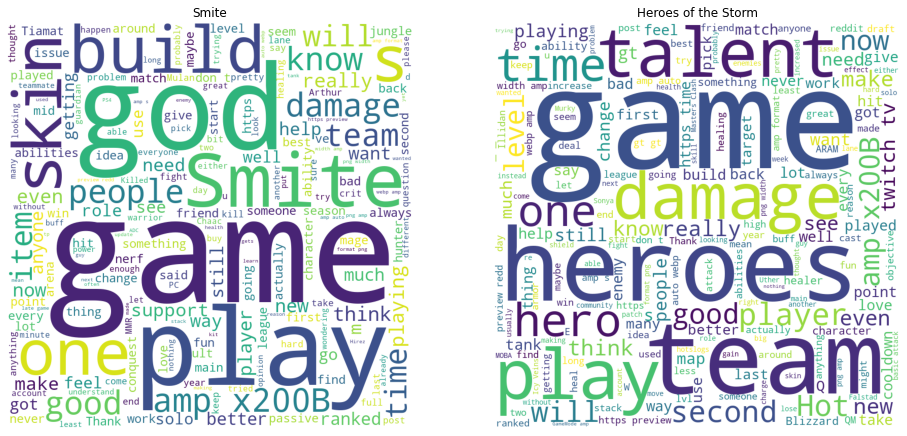

In [30]:
fig , ax = plt.subplots(1, 2, figsize=(16,32))
wordcloud_True = WordCloud(background_color='white',width=800, height=800).generate(' '.join(posts_df_clean[posts_df_clean['subreddit'] == 1]['title_selftext']))
wordcloud_False = WordCloud(background_color='white',width=800, height=800).generate(' '.join(posts_df_clean[posts_df_clean['subreddit'] == 0]['title_selftext'])) 
ax[0].imshow(wordcloud_True)
ax[0].axis('off')
ax[0].set_title('Smite')
ax[1].imshow(wordcloud_False)
ax[1].axis('off')
ax[1].set_title('Heroes of the Storm')
plt.show()

Use the WordCloud to improve wordstop
1. Words like game, play, players will not be used as predictors as they are common words that shows up in both subreddit
2. This gives an idea that god, build, smite would strongly indicate that the post belongs in Smite subreddit
3. Heroes, team, talent would strongly indicate that the post belongs in HoTS subreddit

---

# Model Generation Fuction
1. The function should allow the user to call different models and vectors
2. Allow customization of the parameters
3. Create model and display performance

In [31]:
def Create_Model(n_neighbors= 3,max_features = 5000, min_df=2, max_df=.8, ngram_range = (1,2), vec= 'cvec', model='log', binary = False):
    print('Model:', model)
    print('Vectorizor:', vec)
    
    #VEC: 
    cvec = CountVectorizer(analyzer = "word",
                           tokenizer = None,
                           preprocessor = None,
                           stop_words = None,
                           max_features = max_features,
                           min_df = min_df,
                           max_df = max_df,
                           ngram_range = ngram_range,
                           binary = binary
                           ) 
    
    tvec = TfidfVectorizer(analyzer = "word",
                           tokenizer = None,
                           preprocessor = None,
                           stop_words = None,
                           max_features= max_features,
                           min_df = min_df,
                           max_df = max_df,
                           ngram_range = ngram_range,
                           binary = binary
                           )
    
    if vec == 'cvec':
        train_data_features = cvec.fit_transform(clean_train_posts)
        test_data_features = cvec.transform(clean_test_posts)
    
    elif vec == 'tvec':
        train_data_features = tvec.fit_transform(clean_train_posts)
        test_data_features = tvec.transform(clean_test_posts)
    
    #MODEL:
    if model == 'log':
        lr = LogisticRegression()
        lr.fit(train_data_features, y_train)
        
        print('Accuracy on Train Data:', lr.score(train_data_features, y_train))
        print('Accuracy on Test Data:', lr.score(test_data_features, y_test))
        
        return lr.predict(test_data_features)
    
    elif model == 'knn':
        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(train_data_features, y_train)
        
        print('Accuracy on Train Data:',knn.score(train_data_features, y_train))
        print('Accuracy on Test Data:', knn.score(test_data_features, y_test))
        
        return knn.predict(test_data_features)
    
    elif model == 'mbayes':
        mul = MultinomialNB()
        mul.fit(train_data_features, y_train)
        
        print('Accuracy on Train Data:',mul.score(train_data_features, y_train))
        print('Accuracy on Test Data:', mul.score(test_data_features, y_test))
        
        return mul.predict(test_data_features)
        
    elif model == 'bbayes':
        mul = BernoulliNB()
        mul.fit(train_data_features, y_train)
        
        print('Accuracy on Train Data:',mul.score(train_data_features, y_train))
        print('Accuracy on Test Data:', mul.score(test_data_features, y_test))
        
        return mul.predict(test_data_features)
    
    else:
        pass


In [32]:
LC1 = Create_Model()

Model: log
Vectorizor: cvec
Accuracy on Train Data: 1.0
Accuracy on Test Data: 0.85


In [33]:
LC2 = Create_Model(max_features=3000) 

Model: log
Vectorizor: cvec
Accuracy on Train Data: 1.0
Accuracy on Test Data: 0.8533333333333334


In [34]:
LC3 = Create_Model(max_features=3000, max_df=.95) 

Model: log
Vectorizor: cvec
Accuracy on Train Data: 1.0
Accuracy on Test Data: 0.8533333333333334


In [35]:
LC4 = Create_Model(max_features=3000, ngram_range = (1,1)) 

Model: log
Vectorizor: cvec
Accuracy on Train Data: 1.0
Accuracy on Test Data: 0.8533333333333334


In [36]:
LT1 = Create_Model(vec='tvec') #High Performance

Model: log
Vectorizor: tvec
Accuracy on Train Data: 0.9833333333333333
Accuracy on Test Data: 0.8966666666666666


In [37]:
LT2 = Create_Model(vec='tvec', max_features=3000) #High Performance

Model: log
Vectorizor: tvec
Accuracy on Train Data: 0.9811111111111112
Accuracy on Test Data: 0.8966666666666666


In [38]:
LT3 = Create_Model(vec='tvec', max_df=.95) #High Performance

Model: log
Vectorizor: tvec
Accuracy on Train Data: 0.9833333333333333
Accuracy on Test Data: 0.8966666666666666


In [39]:
LT4 = Create_Model(vec='tvec', ngram_range = (1,1)) #High Performance

Model: log
Vectorizor: tvec
Accuracy on Train Data: 0.9788888888888889
Accuracy on Test Data: 0.8933333333333333


Quite Overfitting (Expected from NLP)
1. The First Models (Count/Vec and LogisticRegression) performed really well, but are obviously overfitting
2. The Second Models (Tf/Vec and LogisticRegression) performed even better. They do not perform 100% accurately on the train data, but they show better performance on test data

---

# Lets Evaluate The Quality Of Our Best Model From The First Set

### Confusion matrix

In [40]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [41]:
def Confusion_Metrix(y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    spec = tn / (tn + fp)
    print(f'Specificity: {round(spec,4)}')
    
    sens = tp / (tp + fn)
    print(f'Sensitivity: {round(sens,4)}')
    
    print('Correctly Predict Smite (TP):', tp)
    print('Correctly Predict HoTS (TN):', tn)
    print('Incorrectly Predict that the post is Smite (FP):', fp)
    print('Incorrectly Predict that the post is HoTS (FN):', fn)

In [42]:
Confusion_Metrix(LT2)

Specificity: 0.9172
Sensitivity: 0.8741
Correctly Predict Smite (TP): 125
Correctly Predict HoTS (TN): 144
Incorrectly Predict that the post is Smite (FP): 13
Incorrectly Predict that the post is HoTS (FN): 18


In [43]:
Confusion_Metrix(LT3)

Specificity: 0.9172
Sensitivity: 0.8741
Correctly Predict Smite (TP): 125
Correctly Predict HoTS (TN): 144
Incorrectly Predict that the post is Smite (FP): 13
Incorrectly Predict that the post is HoTS (FN): 18


# KNN Models

In [44]:
KC1 = Create_Model(model='knn',vec='cvec', max_features=3000, n_neighbors= 10) 

Model: knn
Vectorizor: cvec
Accuracy on Train Data: 0.7777777777777778
Accuracy on Test Data: 0.6533333333333333


In [45]:
KT1 = Create_Model(model='knn', vec='tvec', max_features=3000, n_neighbors= 10) #Performs well

Model: knn
Vectorizor: tvec
Accuracy on Train Data: 0.8888888888888888
Accuracy on Test Data: 0.8433333333333334


# Bayes Model (MultinomialNB, BernoulliNB )

In [46]:
MC1 = Create_Model(model='mbayes', vec='cvec', ngram_range = (1,1), binary=True, min_df=3, max_features = 3000) 

Model: mbayes
Vectorizor: cvec
Accuracy on Train Data: 0.9577777777777777
Accuracy on Test Data: 0.87


In [47]:
MT1 = Create_Model(model='mbayes', vec='tvec', ngram_range = (1,1), max_features = 5000, min_df=2, ) #Best Model

Model: mbayes
Vectorizor: tvec
Accuracy on Train Data: 0.9766666666666667
Accuracy on Test Data: 0.92


In [48]:
BC1 = Create_Model(model='bbayes', vec='cvec', ngram_range = (1,1)) 

Model: bbayes
Vectorizor: cvec
Accuracy on Train Data: 0.7744444444444445
Accuracy on Test Data: 0.6933333333333334


In [49]:
BT1 = Create_Model(model='bbayes', vec='tvec', ngram_range = (1,1))

Model: bbayes
Vectorizor: tvec
Accuracy on Train Data: 0.7744444444444445
Accuracy on Test Data: 0.6933333333333334


# Model Evaluations:

In [50]:
Confusion_Metrix(KT1)

Specificity: 0.8854
Sensitivity: 0.7972
Correctly Predict Smite (TP): 114
Correctly Predict HoTS (TN): 139
Incorrectly Predict that the post is Smite (FP): 18
Incorrectly Predict that the post is HoTS (FN): 29


In [51]:
Confusion_Metrix(MC1)

Specificity: 0.8408
Sensitivity: 0.9021
Correctly Predict Smite (TP): 129
Correctly Predict HoTS (TN): 132
Incorrectly Predict that the post is Smite (FP): 25
Incorrectly Predict that the post is HoTS (FN): 14


---

# Product Model: MultinomialNB with TfidVectorizor 
1. (Logistic Models are slightly too overfitting, so this model is classified as the best one)
2. Good accracy
3. Is not overwhelmed with FN or FP

In [52]:
tvec = TfidfVectorizer(ngram_range = (1,1), min_df=2, max_features = 5000, max_df=.8)
model = MultinomialNB()

train_data_features = tvec.fit_transform(clean_train_posts)
test_data_features = tvec.transform(clean_test_posts)

model.fit(train_data_features, y_train)
        
print('Accuracy on Train Data:',model.score(train_data_features, y_train))
print('Accuracy on Test Data:', model.score(test_data_features, y_test))

Accuracy on Train Data: 0.9766666666666667
Accuracy on Test Data: 0.92


In [53]:
Confusion_Metrix(MT1)

Specificity: 0.9427
Sensitivity: 0.8951
Correctly Predict Smite (TP): 128
Correctly Predict HoTS (TN): 148
Incorrectly Predict that the post is Smite (FP): 9
Incorrectly Predict that the post is HoTS (FN): 15


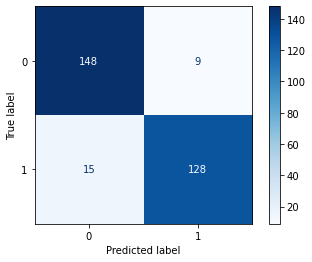

In [54]:
plot_confusion_matrix(model, test_data_features, y_test, cmap='Blues');

In [55]:
counts = pd.DataFrame(train_data_features.toarray(),
                      columns=tvec.get_feature_names())
counts.head()

,aa,ab,aba,abandon,abathur,abilities,ability,able,abroad,absence,...,zeus,zha,zj,zone,zoning,zoom,zt,zul,zuljin,zwhydra
0,0.0,0.0,0.0,0.0,0.0,0.027068,0.0836,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023243,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [56]:
evaluation_df = pd.DataFrame(data= {'HoTS':model.feature_log_prob_[0], 'Smite':model.feature_log_prob_[1] , 'Word':counts.columns})

In [57]:
evaluation_df['Smite'] = evaluation_df['Smite'].map(lambda x: x*-1)

In [58]:
evaluation_df['HoTS'] = evaluation_df['HoTS'].map(lambda x: x*-1)

In [59]:
evaluation_df['Compare'] = evaluation_df['HoTS']-evaluation_df['Smite']

In [60]:
evaluation_df.sort_values(by='Compare', ascending = False).head(10)

,HoTS,Smite,Word,Compare
1534,8.599180,5.921988,god,2.677192
747,8.795225,6.781036,conquest,2.014189
3615,8.795225,6.815007,tiamat,1.980218
1876,8.332991,6.401058,item,1.931933
3674,8.795225,7.011796,tp,1.783429
1912,8.748983,6.985175,jungle,1.763808
2548,8.795225,7.234635,pc,1.560590
594,8.795225,7.261765,chaac,1.533461
832,8.795225,7.281724,crit,1.513501
3351,8.795225,7.305647,starter,1.489578


In [61]:
hots_word = evaluation_df.sort_values(by='Compare').head(15)
hots_word

,HoTS,Smite,Word,Compare
1662,5.768361,8.350043,hero,-2.581681
3508,6.336575,8.715884,talent,-2.379309
201,6.890272,8.715884,aram,-1.825612
409,7.096075,8.715884,blizzard,-1.619809
2766,7.163812,8.715884,qm,-1.552071
3232,7.208266,8.715884,sl,-1.507617
1759,7.272701,8.715884,illidan,-1.443182
1288,7.409938,8.715884,falstad,-1.305946
2163,7.433029,8.715884,march,-1.282854
3716,7.059477,8.334986,tv,-1.275509


In [62]:
evaluation_df[(evaluation_df['Compare'] < .001) & (evaluation_df['Compare'] > -.001)].sort_values(by='Compare', ascending = False)

,HoTS,Smite,Word,Compare
3797,7.175173,7.174181,use,0.000992
3583,8.716556,8.715884,thirst,0.000673
491,7.497556,7.497008,buff,0.000548
1399,8.381702,8.381183,follow,0.000520
1835,8.512727,8.512283,installed,0.000444
1198,7.618429,7.618230,etc,0.000199
3927,8.587545,8.587364,whereas,0.000181
3235,8.634296,8.634201,slapping,0.000095
879,8.485982,8.485935,dash,0.000048
2062,8.622039,8.622332,listening,-0.000293


1. 'Compare' shows correlation labels vs. word
2. Positive 'Compare' would indicate that the Word is more unique for Label 1 (Smite)
3. Negative 'Compare' would indicate that the Word is more unique for Label 0 (Heroes of the Storm in this case)
4. 'Compare' close to 0 indicated that the Word isn't use heavily to make prediction (due to the word showing up often (or rarely) in both subreddit)

## Visualizations

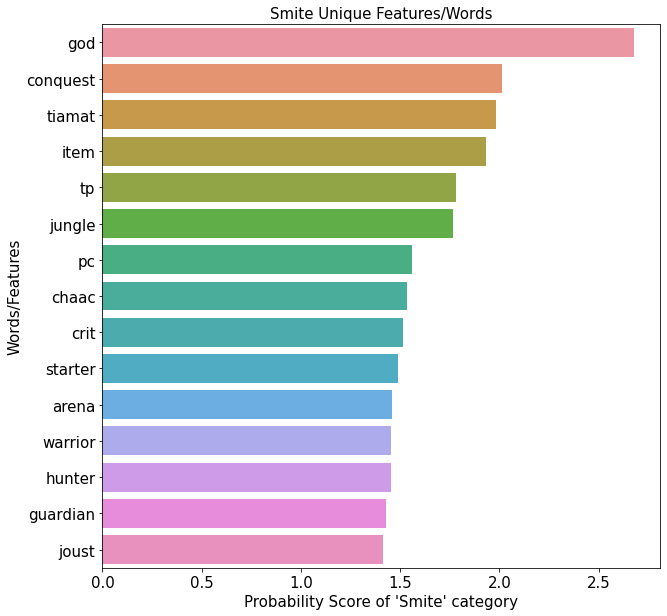

In [63]:
plt.figure(figsize=(10,10))
plt.title('Smite Unique Features/Words',fontsize=15)
sns.barplot(data=evaluation_df.sort_values(by='Compare',ascending=False).head(15),x='Compare',y='Word',orient='h')
plt.xlabel("Probability Score of 'Smite' category",fontsize=15)
plt.ylabel('Words/Features',fontsize=15)
plt.tick_params(labelsize=15)

In [64]:
hots_word['Compare'] = hots_word['Compare'].apply(lambda x: np.abs(x))

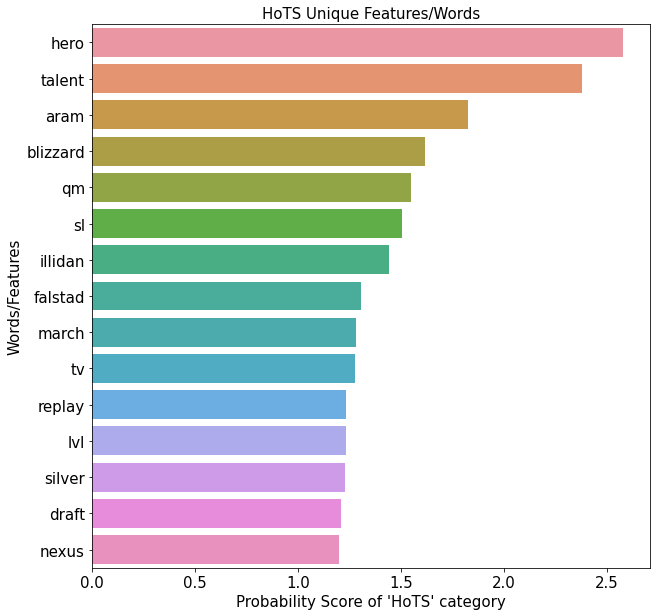

In [83]:
plt.figure(figsize=(10,10))
plt.title('HoTS Unique Features/Words',fontsize=15)
sns.barplot(data=hots_word,x='Compare',y='Word',orient='h')
plt.xlabel("Probability Score of 'HoTS' category",fontsize=15)
plt.ylabel('Words/Features',fontsize=15)
plt.tick_params(labelsize=15)

---

## Look Into Missclassified Posts

In [66]:
miss_class_df = pd.DataFrame({'Prediction':MT1, 'True':y_test, 'Text': clean_test_posts})

In [67]:
miss_class_df['Incorrect'] = miss_class_df['True'] - miss_class_df['Prediction']
miss_class_df['Incorrect'] = miss_class_df['Incorrect'].map(lambda x: x if x == 0 else 1)

In [68]:
miss_class_df.head()

,Prediction,True,Text,Incorrect
1074,0,0,wednesday rage thread february march post caps...,0
1140,0,0,abathur super fast deep tunnel edit turns anim...,0
808,0,0,good new li li hi everyone talking li li got h...,0
94,1,1,death toll sooo build death toll literally any...,0
867,0,0,mephisto undocumented change durance hate dela...,0


In [69]:
miss_class_df = miss_class_df[miss_class_df['Incorrect'] == 1]
miss_class_df.reset_index(drop=True, inplace=True)

In [70]:
miss_class_df.head()

,Prediction,True,Text,Incorrect
0,1,0,possible controller hey anyone played using co...,1
1,1,0,add black ops specialists saying,1
2,1,0,troll detection technique tyrande singapore se...,1
3,0,1,thorns popping hey guy able pop thorn stunned,1
4,1,0,missing mount bug anyone know shit gonna get f...,1


## Some Incorrectly Predicted Posts 
1. (Identify Limitation and Improvable Filtering/Stopwords)

In [71]:
def id_problem(i):
    print('Text:', miss_class_df['Text'][i])
    if miss_class_df['True'][i] == 0:
        print('Correct: HoTS')
        print('Predicted: Smite')
    else:
        print('Correct: Smite')
        print('predicted: HoTS')
    list_word = set(miss_class_df['Text'][i].split())
    result = pd.DataFrame({'Word':[],'Compare':[]})
    for i in list_word:
        temp_df = evaluation_df[evaluation_df['Word'] == i][['Word','Compare']]
        result = pd.concat([result, temp_df], axis=0)
    result = result.sort_values(by='Compare',ascending = False)
    
    return result

In [72]:
id_problem(0)

Text: possible controller hey anyone played using controller strictly dependent
Correct: HoTS
Predicted: Smite


,Word,Compare
782,controller,1.127485
167,anyone,0.286119
3803,using,0.143740
2647,possible,-0.008430
2610,played,-0.050096
944,dependent,-0.062079
1672,hey,-0.431273


1. Controller leans to Smite due to the fact that Smite is released on console as well.
2. This post talks about controllers on HoTS, which is not controller supportted right now. (Rare discussion)

---

In [73]:
id_problem(1)

Text: add black ops specialists saying
Correct: HoTS
Predicted: Smite


,Word,Compare
389,black,0.530049
3058,saying,0.455857
48,add,-0.270475


1. In this case the post does not offer enough text for decent evaluation

---

1. Test data may be too small. Word 'Skin' leans toward 'Smite' subreddit, despite both games having skins as an attribute.
2. 'Skin' will now be romoved from the texts. (The post is now correctly predicted and no longer in the miss_class_df)

---

In [74]:
id_problem(2)

Text: troll detection technique tyrande singapore server winrate afks spam owl thought wa pretty funny carried anyway hard automate detection account ban manually simple statement least button qwe consistently pressed minute multiple suggestion hire blizard thank
Correct: HoTS
Predicted: Smite


,Word,Compare
3294,spam,0.761972
1460,funny,0.465363
2683,pretty,0.411933
3591,thought,0.402193
3568,thank,0.388505
313,ban,0.371102
3204,simple,0.330725
28,account,0.318443
556,carried,0.311738
3700,troll,0.266333


1. This shows that our model is spelling sensitive. In this case, the word 'Blizzard' should have already indicate that this post belongs in HoTS. However, the person who published this post had misspelled it. Our model was not able to comprepend any misspelled words.

---

In [75]:
id_problem(3)

Text: thorns popping hey guy able pop thorn stunned
Correct: Smite
predicted: HoTS


,Word,Compare
3588,thorn,0.381517
7,able,0.030975
1588,guy,-0.131186
2638,popping,-0.206013
3421,stunned,-0.254280
2637,pop,-0.335040
1672,hey,-0.431273


1. Once again, the size of the text is too small and general to be correctly predicted (additionally, it contains no strong indicative words)

---

1. I removed 'League' as it was problematic. The word showed up in both subreddit often, but leads the model to think the post belongs in 'HoTS' subreddit when it shouldn't. This inproves the quality of the prediction greatly
2. 'Additionally' was also removed as it shouldn't be an indicative word

---

## Conclusion

1. The model that predicts most accurately is a MultinomialNB model with TfidVectorizor. (Our product model)
2. It has roughly 92% accuracy.
3. It is a little overfitting (to be expected from regression models).
4. It is not overwhelmed with FN or FP (can be intrepretted as a good model)
5. The model predicts that these are the unique words for Smite category: god, conquest, tiamat, item, tp (Teleport), jungle
6. And for Heroes of the Storm category:  hero, talent, aram, blizzard, qm (Quick Match), sl (Storm League)
7. Limitations: 
    1. Any discussion that are seldom to occur are likely to be predicted into the wrong category.
    2. Short texts have higher chances of being predicted incorrectly
    3. Model is sensitive to spelling errors.